In [4]:
################################################################################
# [셀1] : 모듈 임포트 및 한글 폰트 설정
################################################################################
import random
import math
from collections import Counter
from typing import List, Dict, Optional
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib


# 한글 폰트 & 마이너스 깨짐 방지
mpl.rcParams["font.family"] = "Malgun Gothic"
mpl.rcParams["axes.unicode_minus"] = False

COLOR_PALETTE = sns.color_palette("YlGnBu", n_colors=5)
REGION_MAP: Dict[str, int] = {}
REGION_NAME_MAP: Dict[int, str] = {}

c:\Users\delta\anaconda3\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
################################################################################
# [셀2] : Agent 클래스 정의
################################################################################
class Agent:
    """개별 행위자(시민) 객체"""

    def __init__(self, agent_id: int, social_marker: int, group_id: int | None = None):
        self.id = agent_id
        self.social_marker = social_marker      # 0~4 (A, B, C, D, E)
        self.group_id = group_id                # 지역(패치) ID
        self.adoption_state = False             # 현재 혁신 채택 여부
        self.next_adoption_state = False        # 비동기 계산용 버퍼

    # ------------------------------------------------------------------
    def decide_adoption(
        self,
        observed_agents: List["Agent"],
        lambda_param: float,
        b_scalar: float,
    ) -> None:
        """관찰한 이웃 정보로 다음 시점 채택 여부 결정"""
        M_counts = [0] * 5  # 마커별 채택자 수
        total_obs = len(observed_agents)

        # 관찰한 이웃 중 채택자 카운트
        for obs in observed_agents:
            if obs.adoption_state:
                M_counts[obs.social_marker] += 1

        adopters = sum(M_counts)
        if total_obs == 0:
            # 이웃이 없으면 상태 유지
            self.next_adoption_state = self.adoption_state
            return

        # 채택 비율 기반 전염력 F
        F = (adopters / total_obs) ** lambda_param

        # 내·외집단 가중치 V
        i = self.social_marker
        MI = M_counts[i]                 # in-group 채택자
        MO = adopters - MI               # out-group 채택자
        if adopters == 0:
            V = 0.0
        elif MO == 0:
            V = 1.0
        else:
            V = (1 - b_scalar) + b_scalar / (1 + math.exp(-(MI - MO)))

        # 최종 채택 확률 p
        p = F * V
        if self.adoption_state:
            # 이미 채택 → 유지 확률로 계산
            self.next_adoption_state = random.random() <= p
        else:
            self.next_adoption_state = random.random() < p

    # ------------------------------------------------------------------
    def apply_next_state(self) -> None:
        """동기적 업데이트 (버퍼 → 실제 상태)"""
        self.adoption_state = self.next_adoption_state

In [6]:
################################################################################
# [셀3] : DemographicManager 클래스 정의 (지역/인구/에이전트 생성 및 관리)
################################################################################
class DemographicManager:
    """지역·인구·행위자 생성 및 관리"""

    def __init__(
        self,
        n_of_group: int,
        n_of_agent_per_group: int,
        *,
        regions_custom: bool = False,
        region_matrix: Optional[List[List[float]]] = None,
        populations_custom: bool = False,
        population_matrixs: Optional[List[int]] = None,
    ) -> None:
        self.n_of_group = n_of_group
        self.n_of_agent_per_group = n_of_agent_per_group
        self.regions_custom = regions_custom
        self.region_matrix = region_matrix
        self.populations_custom = populations_custom
        self.population_matrixs = population_matrixs

        self.agents: List[Agent] = []
        self.group_dict: Dict[int, List[Agent]] = {}
        self._create_agents()

    # ------------------------------------------------------------------
    def _create_agents(self) -> None:
        """행위자 객체 생성"""
        if not self.regions_custom:
            raise ValueError("region_matrix가 필요합니다 (regions_custom=True)")

        aid = 0
        for pid in range(self.n_of_group):
            # ---------------- 인구 규모 설정 ----------------
            pop = (
                self.population_matrixs[pid]
                if self.populations_custom and self.population_matrixs is not None
                else self.n_of_agent_per_group
            )

            # ---------------- 마커 비율 기반 배치 ----------------
            g0, g1, g2, g3, g4 = self.region_matrix[pid]
            s = g0 + g1 + g2 + g3 + g4 or 1
            fracs = [g0 / s, g1 / s, g2 / s, g3 / s, g4 / s]
            counts = [int(round(pop * p)) for p in fracs]
            # 반올림 오차 보정 (여분은 그룹 C에)
            counts[2] += pop - sum(counts)

            # 행위자 생성
            patch_agents: List[Agent] = []
            for marker, cnt in enumerate(counts):
                for _ in range(cnt):
                    patch_agents.append(Agent(aid, marker, pid))
                    aid += 1

            self.agents.extend(patch_agents)
            self.group_dict[pid] = patch_agents

    # ------------------------------------------------------------------
    def initialize_adopters(self, n_init: int, patch_idx: Optional[int] = None) -> None:
        """초기 혁신 채택자 지정"""
        if patch_idx is None or patch_idx not in self.group_dict:
            chosen = random.sample(self.agents, n_init)
        else:
            pool = self.group_dict[patch_idx]
            chosen = pool if len(pool) <= n_init else random.sample(pool, n_init)

        for ag in chosen:
            ag.adoption_state = True
            ag.next_adoption_state = True

    # ------------------------------------------------------------------
    def __len__(self) -> int:
        return len(self.agents)

In [7]:
################################################################################
# [셀4] : Simulation 클래스 정의 (시뮬레이션 핵심 로직)
################################################################################
class Simulation:
    """혁신 확산 시뮬레이션"""

    def __init__(
        self,
        *,
        n_of_group: int,
        n_of_agent_per_group: int,
        regions_custom: bool = False,
        region_matrix: Optional[List[List[float]]] = None,
        populations_custom: bool = False,
        population_matrixs: Optional[List[int]] = None,
        m: int = 30,
        f: float = 0.7,
        mu: float = 0.05,
        lambda_param: float = 0.1,
        b_scalar: float = 0.9,
        init_adopt_n: int = 5,
        init_adopt_patch_index: Optional[int] = None,
        store_states: bool = False,
        info_scope: str = "global",
    ) -> None:
        # ---------------- 파라미터 저장 ----------------
        self.info_scope = info_scope.lower()
        self.m = m
        self.f = f
        self.mu = mu
        self.lambda_param = lambda_param
        self.b_scalar = b_scalar
        self.store_states = store_states

        # ---------------- 인구/지역 매니저 ----------------
        self.demo = DemographicManager(
            n_of_group,
            n_of_agent_per_group,
            regions_custom=regions_custom,
            region_matrix=region_matrix,
            populations_custom=populations_custom,
            population_matrixs=population_matrixs,
        )

        self.agents = self.demo.agents
        self.group_dict = self.demo.group_dict
        self.n = len(self.demo)

        self.demo.initialize_adopters(init_adopt_n, init_adopt_patch_index)

        # ---------------- 기록용 버퍼 ----------------
        self.time_steps: List[int] = []
        self.group_rate_history: Dict[int, List[float]] = {k: [] for k in range(5)}
        self.total_rate_history: List[float] = []
        self.global_pol_history: List[float] = []
        self.local_pol_history: List[float] = []
        self.adoption_snapshots: Optional[List[Dict[int, List[bool]]]] = [] if store_states else None

    # ------------------------------------------------------------------
    def run_simulation(self, max_time_steps: int = 100) -> None:
        """시뮬레이션 메인 루프"""
        for t in tqdm(range(max_time_steps), desc="Simulation"):
            self._one_step()
            self._update_states_synchronously()
            self._record_stats(t)

    # ------------------------------------------------------------------
    def _one_step(self) -> None:
        random.shuffle(self.agents)
        for ag in self.agents:
            if random.random() > self.mu:
                # 변동 없음
                ag.next_adoption_state = ag.adoption_state
                continue

            obs = self._sample_observed_agents(ag, self.m)
            ag.decide_adoption(obs, self.lambda_param, self.b_scalar)

    # ------------------------------------------------------------------
    def _sample_observed_agents(self, agent: Agent, m: int) -> List[Agent]:
        """관찰 대상 샘플링 – 이동 확률 행렬 존재 시 사용"""

        # 이동 행렬이 없으면 (global + local 비율)
        local_cnt = np.random.binomial(m, self.f)
        local_pool = self.group_dict[agent.group_id][:]
        res = random.sample(local_pool, min(local_cnt, len(local_pool)))

        remain = m - len(res)
        global_pool = [x for pid, plist in self.group_dict.items() if pid != agent.group_id for x in plist]
        res.extend(random.sample(global_pool, min(remain, len(global_pool))))
        return res

    # ------------------------------------------------------------------
    def _update_states_synchronously(self) -> None:
        for ag in self.agents:
            ag.apply_next_state()

    # ------------------------------------------------------------------
    def _record_stats(self, t: int) -> None:
        totals = [0] * 5
        adopts = [0] * 5
        for ag in self.agents:
            m = ag.social_marker
            totals[m] += 1
            adopts[m] += ag.adoption_state

        # 그룹별 채택률 기록
        for m in range(5):
            rate = adopts[m] / totals[m] if totals[m] else 0.0
            self.group_rate_history[m].append(rate)

        # 전체 평균 채택률
        total_rate = sum(adopts) / self.n
        self.total_rate_history.append(total_rate)

        # 간단 전역 양극화 (A,B vs D,E)
        eff_A = 1000 * (adopts[0] + adopts[1]) / (totals[0] + totals[1] or 1)
        eff_B = 1000 * (adopts[3] + adopts[4]) / (totals[3] + totals[4] or 1)
        pol = abs(eff_A - eff_B) / (eff_A + eff_B) if eff_A + eff_B else 0.0
        self.global_pol_history.append(pol)

        # (선택) 지역 양극화 – 미구현
        self.local_pol_history.append(0.0)

        # 타임스텝 저장
        self.time_steps.append(t)

        # 스냅샷 저장
        if self.store_states:
            self.adoption_snapshots.append({pid: [ag.adoption_state for ag in plist] for pid, plist in self.group_dict.items()})

In [8]:
################################################################################
# [셀5] : Plot 전용 클래스 정의
################################################################################
class SimulationPlotter:
    """채택률·양극화·스냅샷 시각화"""

    # 그룹별 색상 지정
    COLOR_MAP = {k: COLOR_PALETTE[k] for k in range(5)}
    BASE_COLOR_MAP = {k: (*COLOR_PALETTE[k], 0.25) for k in range(5)}
    LABEL_MAP = {0: "Group A", 1: "Group B", 2: "Group C", 3: "Group D", 4: "Group E"}

    def __init__(self, sim: Simulation):
        self.sim = sim
        # REGION_NAME_MAP 은 [셀6]에서 덮어쓴 후 인스턴스를 생성해야 합니다.
        self.region_names = REGION_NAME_MAP

    # ------------------------------------------------------------------
    def print_final_results(self) -> None:
        if not self.sim.time_steps:
            print("[WARN] 기록 없음")
            return
        idx = -1
        print("===== 최종 채택률 =====")
        for m in range(5):
            print(f"{self.LABEL_MAP[m]:8s}: {self.sim.group_rate_history[m][idx]*100:6.2f}%")
        print(f"전체           : {self.sim.total_rate_history[idx]*100:6.2f}%")
        print(f"전역 양극화    : {self.sim.global_pol_history[idx]*100:6.2f}%")

    # ------------------------------------------------------------------
    def plot_group_adoption_rates(self) -> None:
        plt.figure(figsize=(6, 4))
        for m in range(5):
            plt.plot(
                self.sim.time_steps,
                self.sim.group_rate_history[m],
                label=self.LABEL_MAP[m],
                color=self.COLOR_MAP[m],
            )
        # 전체 평균 채택률 추가
        plt.plot(
            self.sim.time_steps,
            self.sim.total_rate_history,
            label="Total Avg",
            color="black",
        )
        plt.ylim(0, 1)
        plt.xlabel("Time")
        plt.ylabel("Adoption rate")
        plt.legend()
        # plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    def plot_polarization(self) -> None:
        plt.figure(figsize=(6, 4))
        plt.plot(
            self.sim.time_steps,
            self.sim.global_pol_history,
            label="Global Polarization",
            color="#209b87",
        )
        plt.plot(
            self.sim.time_steps,
            self.sim.local_pol_history,
            label="Local Polarization",
            color="#ffce63",
        )
        plt.ylim(0, 1)
        plt.xlabel("Time")
        plt.ylabel("Polarization")
        plt.legend()
        #plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ------------------------------------------------------------------
    def plot_snapshot(self, time_step: int, region_id: Optional[int] = None) -> None:
        if not self.sim.store_states:
            print("[WARN] 스냅샷 저장 안 함")
            return
        if time_step < 0 or time_step >= len(self.sim.adoption_snapshots):
            print("[WARN] time_step 범위 오류")
            return

        snap = self.sim.adoption_snapshots[time_step]

        def color(marker: int, adopted: bool):
            return self.COLOR_MAP[marker] if adopted else self.BASE_COLOR_MAP[marker]

        # ---------------- 단일 지역 스냅샷 ----------------
        if region_id is not None:
            if region_id not in snap:
                print("[WARN] region_id 없음")
                return
            plist = self.sim.group_dict[region_id]
            states = snap[region_id]
            N = len(plist)
            g = int(math.sqrt(N)) + 1
            xs = [i % g for i in range(N)]
            ys = [i // g for i in range(N)]
            cs = [color(ag.social_marker, states[i]) for i, ag in enumerate(plist)]

            plt.figure(figsize=(4, 4))
            plt.scatter(xs, ys, c=cs, s=60, marker="s")
            plt.gca().invert_yaxis()
            plt.xticks([])
            plt.yticks([])
            plt.title(f"{self.region_names.get(region_id, f'R{region_id}')} | t={time_step}")
            plt.show()
            return

        # ---------------- 모든 지역 스냅샷 ----------------
        pids = sorted(snap.keys())
        n = len(pids)
        ncols = 5
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

        for i, pid in enumerate(pids):
            ax = axes[i // ncols][i % ncols]
            plist = self.sim.group_queryset(pid) if hasattr(self.sim, 'group_queryset') else self.sim.group_dict[pid]
            states = snap[pid]
            N = len(plist)
            if N == 0:
                ax.axis("off")
                continue
            g = int(math.sqrt(N)) + 1
            xs = [j % g for j in range(N)]
            ys = [j // g for j in range(N)]
            cs = [color(plist[j].social_marker, states[j]) for j in range(N)]
            ax.scatter(xs, ys, c=cs, s=30, marker="s")
            ax.set_title(self.region_names.get(pid, f"R{pid}"))
            ax.invert_yaxis()
            ax.set_xticks([])
            ax.set_yticks([])

        # 빈 subplot 제거
        for j in range(i + 1, nrows * ncols):
            fig.delaxes(axes[j // ncols][j % ncols])

        fig.suptitle(f"Snapshot  t={time_step}", fontsize=16)
        plt.tight_layout()
        plt.show()

In [9]:
################################################################################
# [셀6] : 시뮬레이션에 필요한 자료 로드 + 샘플 시뮬레이션 실행
################################################################################

# 지역별 마커 비율 (각 행: g0~g4 비율) ------------------------------------------------
df_region = pd.read_excel("KHUDATA_group.xlsx", sheet_name="주택", index_col=0).astype(float)
regions_matrixs = df_region.values.tolist()

# Excel 인덱스를 기반으로 지역 이름 매핑 생성
REGION_MAP.clear()
REGION_MAP.update({name: idx for idx, name in enumerate(df_region.index.tolist())})
REGION_NAME_MAP.clear()
REGION_NAME_MAP.update({v: k for k, v in REGION_MAP.items()})

# 실제 인구수 (28개 지역) --------------------------------------------------------------
df_pop = pd.read_excel("KHUDATA_population.xlsx", index_col=0).astype(int)
assert len(df_pop) == 28, "KHUDATA_population.xlsx 는 28개 지역을 포함해야 합니다."
populations_matrixs = df_pop["인원수"].values.tolist()


if True:  # 테스트 실행 시 True
    sim = Simulation(
        n_of_group=28,
        n_of_agent_per_group=500,        # 실인구 사용 시 의미 없음

        regions_custom=True,
        region_matrix=regions_matrixs,

        populations_custom=True,
        population_matrixs=populations_matrixs,

        f=0.7,
        m=30,
        mu=0.05,
        lambda_param=0.3,
        b_scalar=0.7,
        init_adopt_n=5,
        init_adopt_patch_index=0,
        store_states=True,
    )

sim.run_simulation(max_time_steps=400)
print("샘플 시뮬레이션 완료.")

Simulation: 100%|██████████| 400/400 [01:20<00:00,  4.96it/s]

샘플 시뮬레이션 완료.


===== 최종 채택률 =====
Group A :  27.58%
Group B :  59.78%
Group C :  29.00%
Group D :  20.88%
Group E :  20.11%
전체           :  39.55%
전역 양극화    :  39.48%


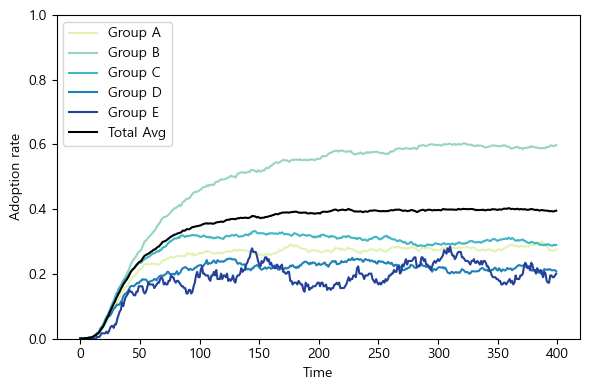

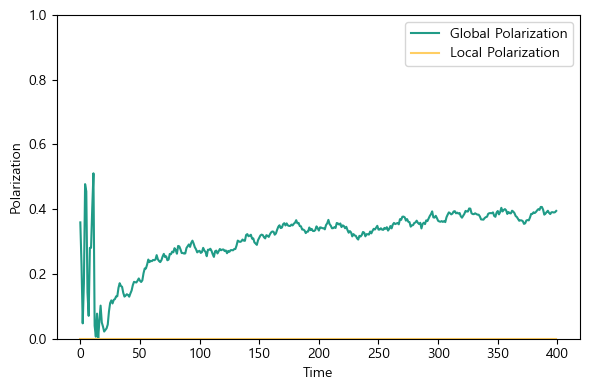

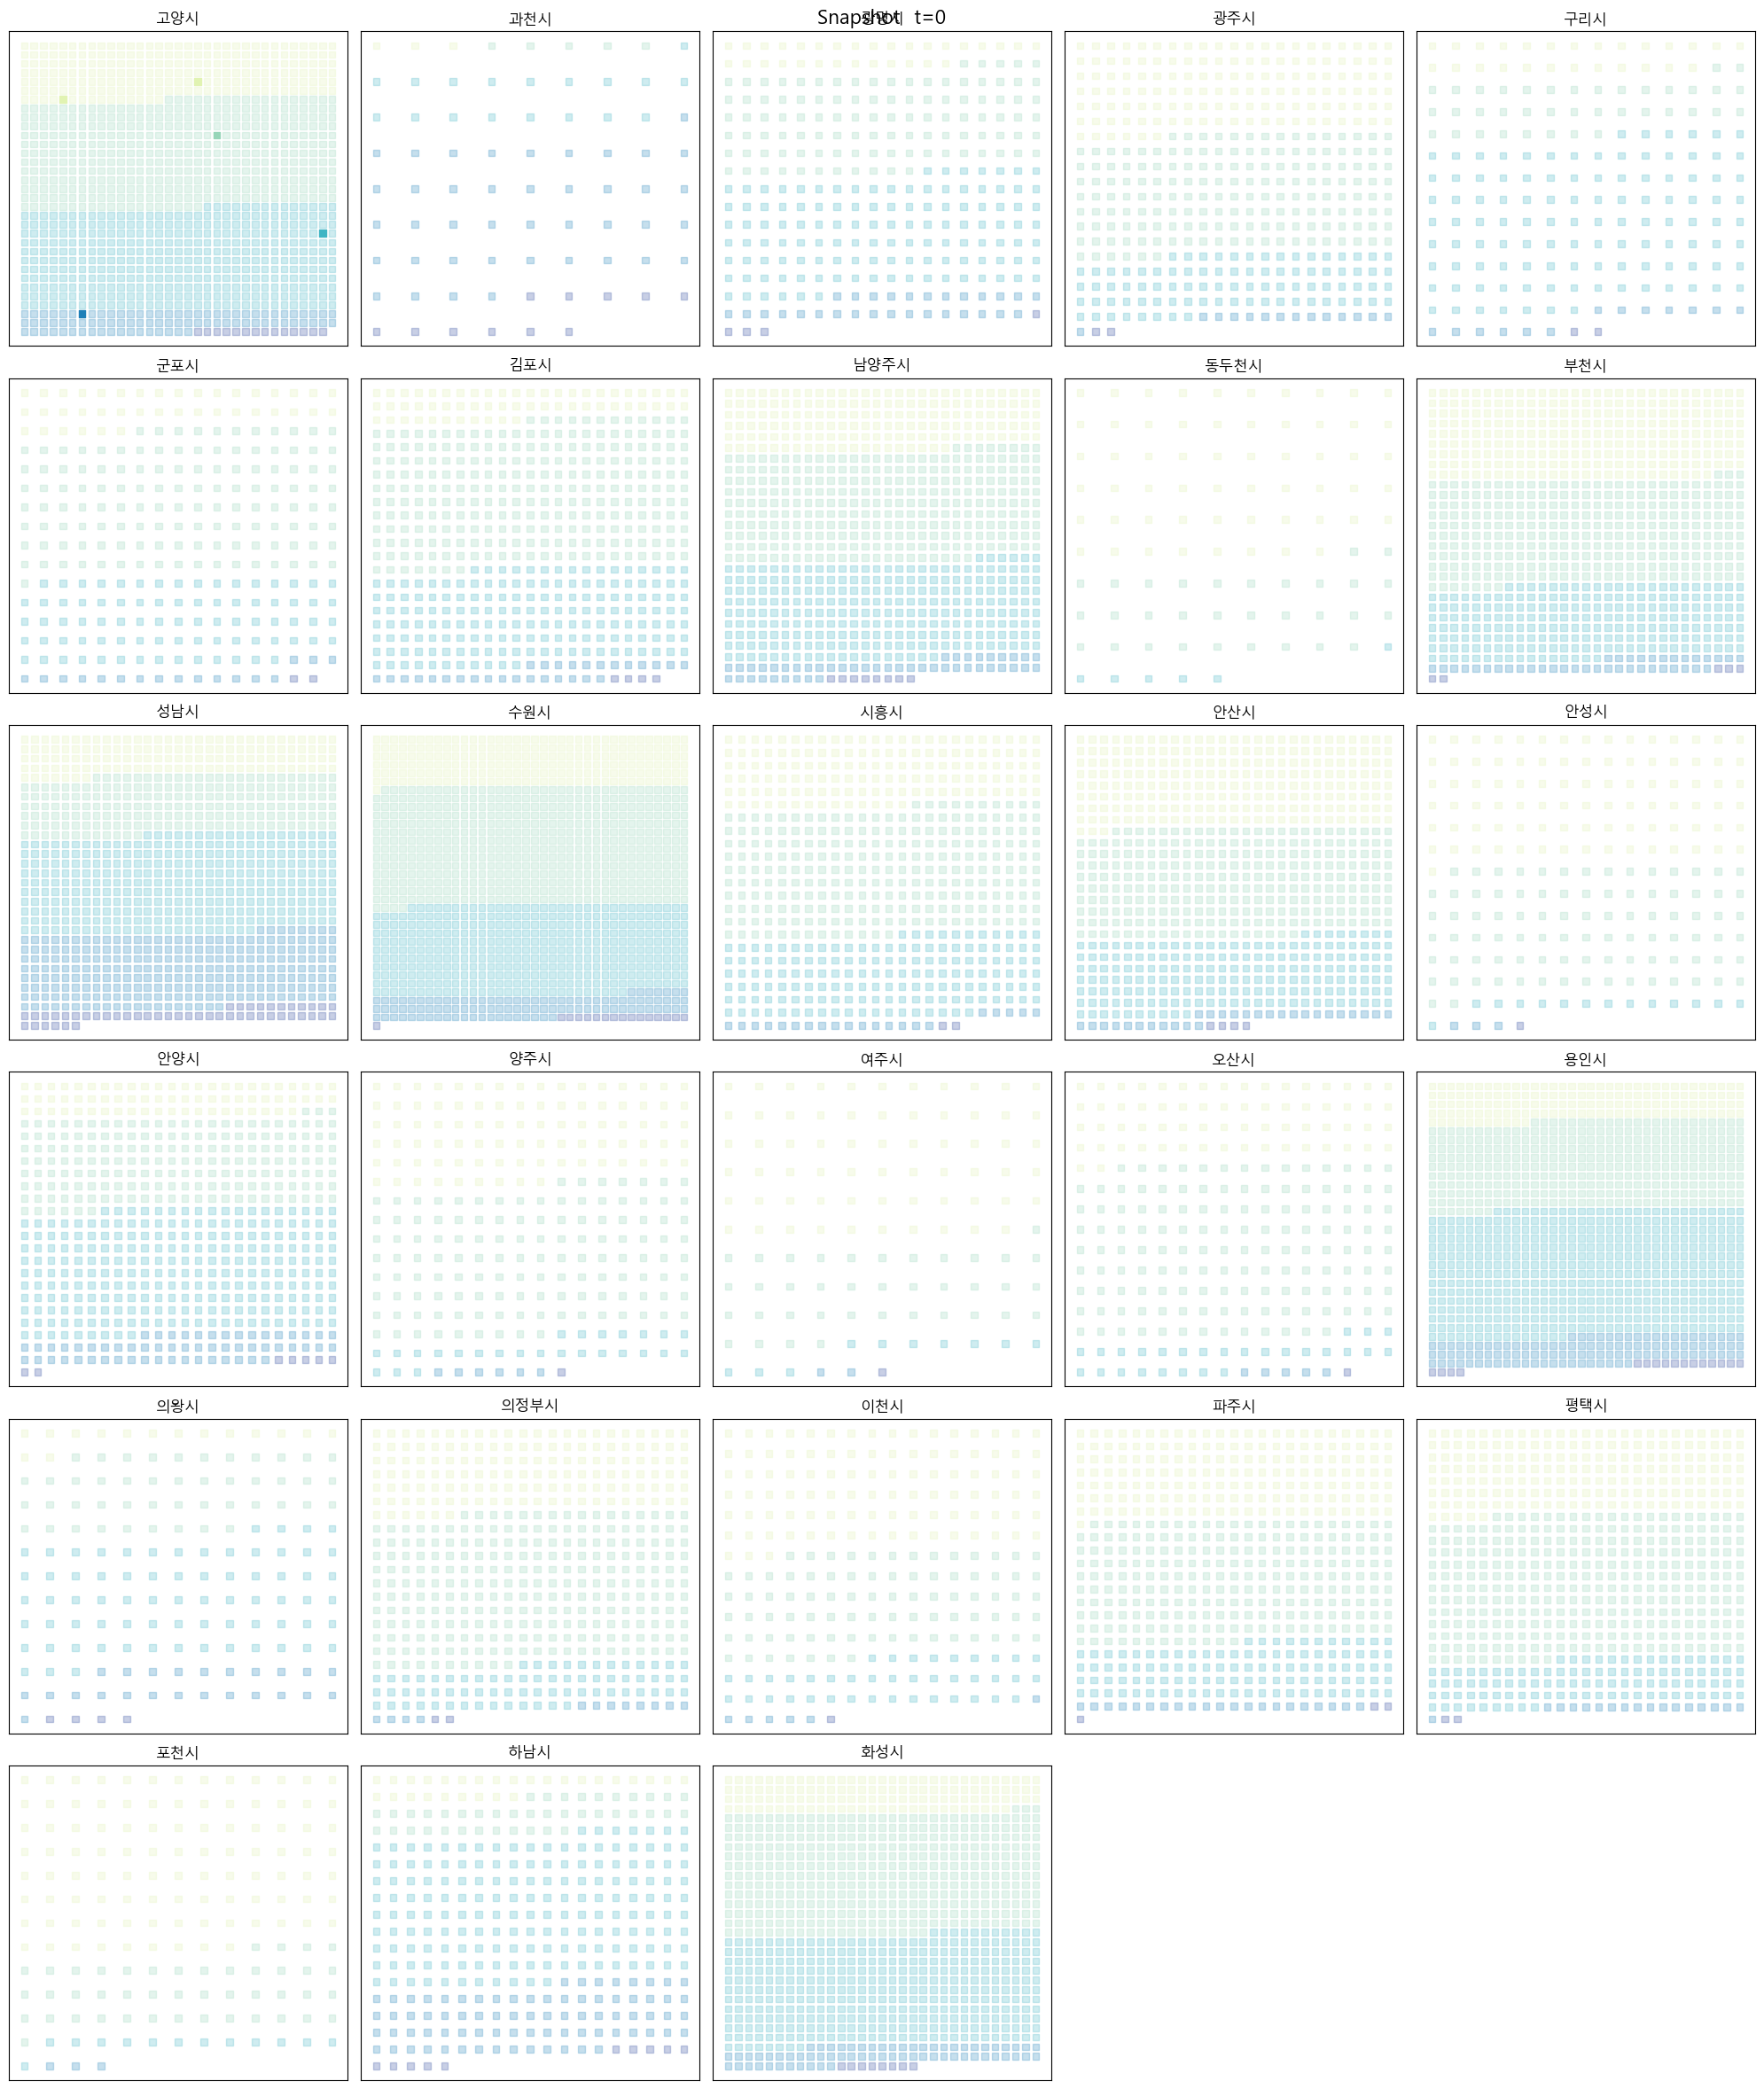

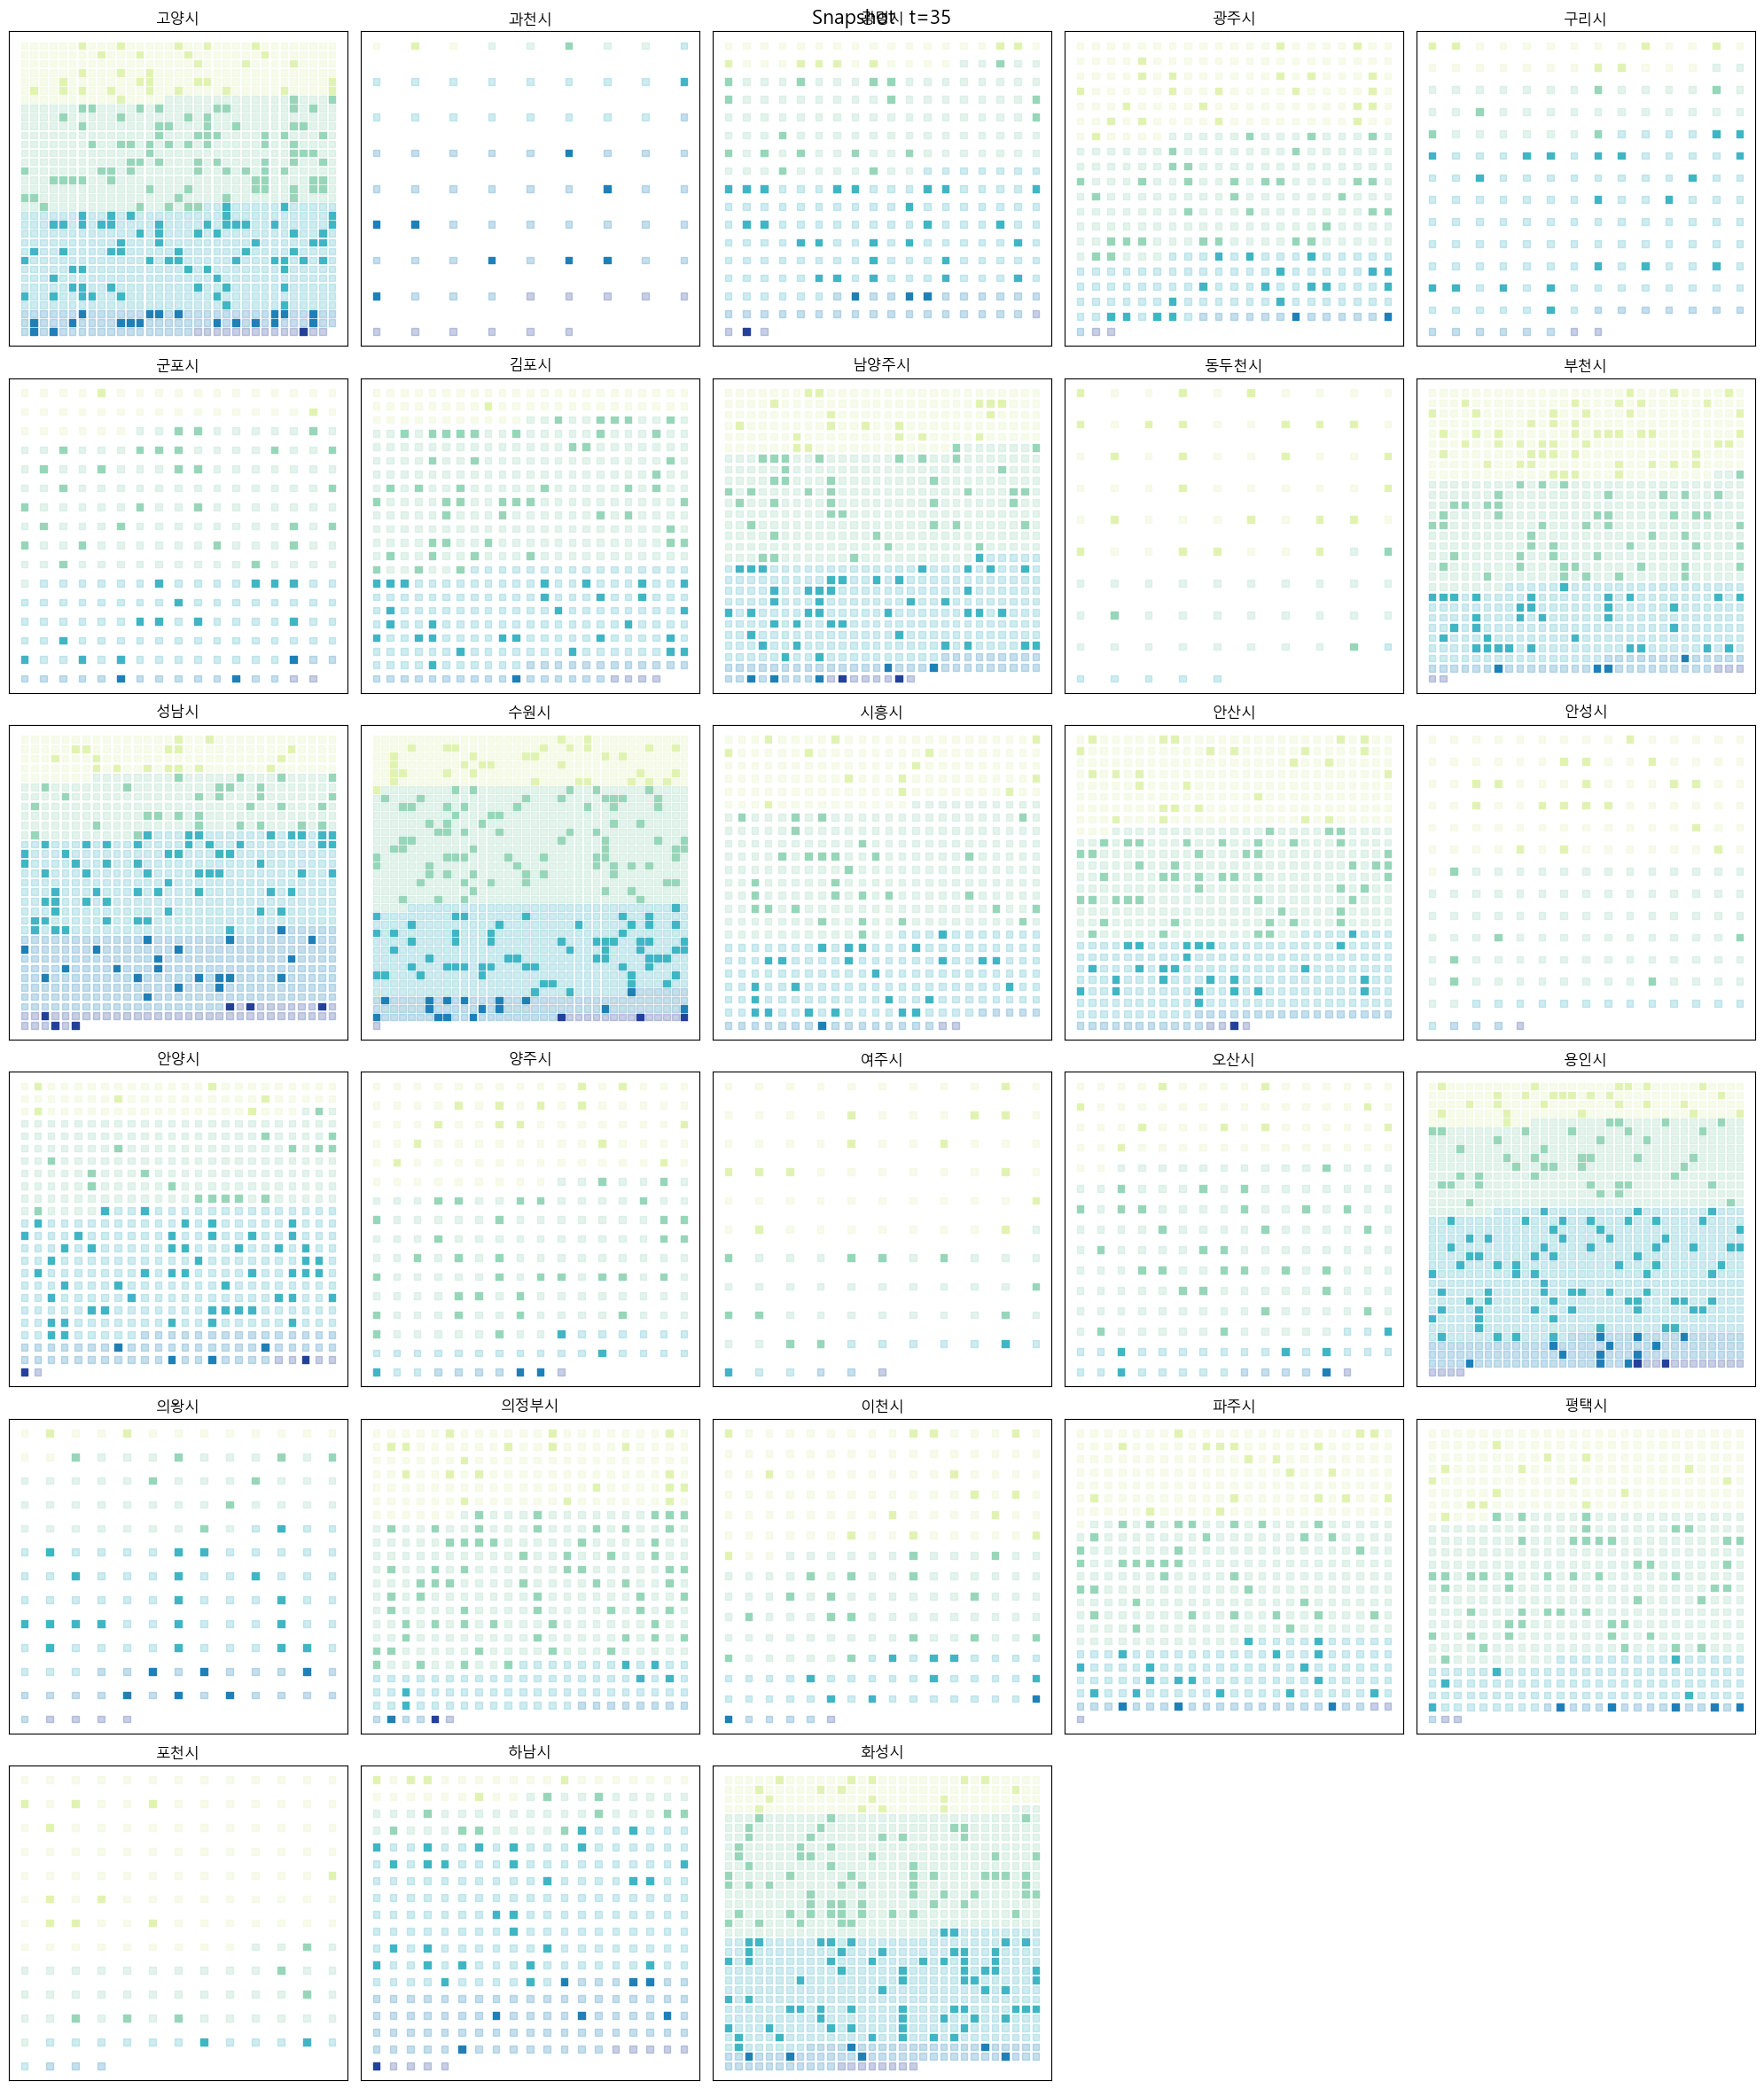

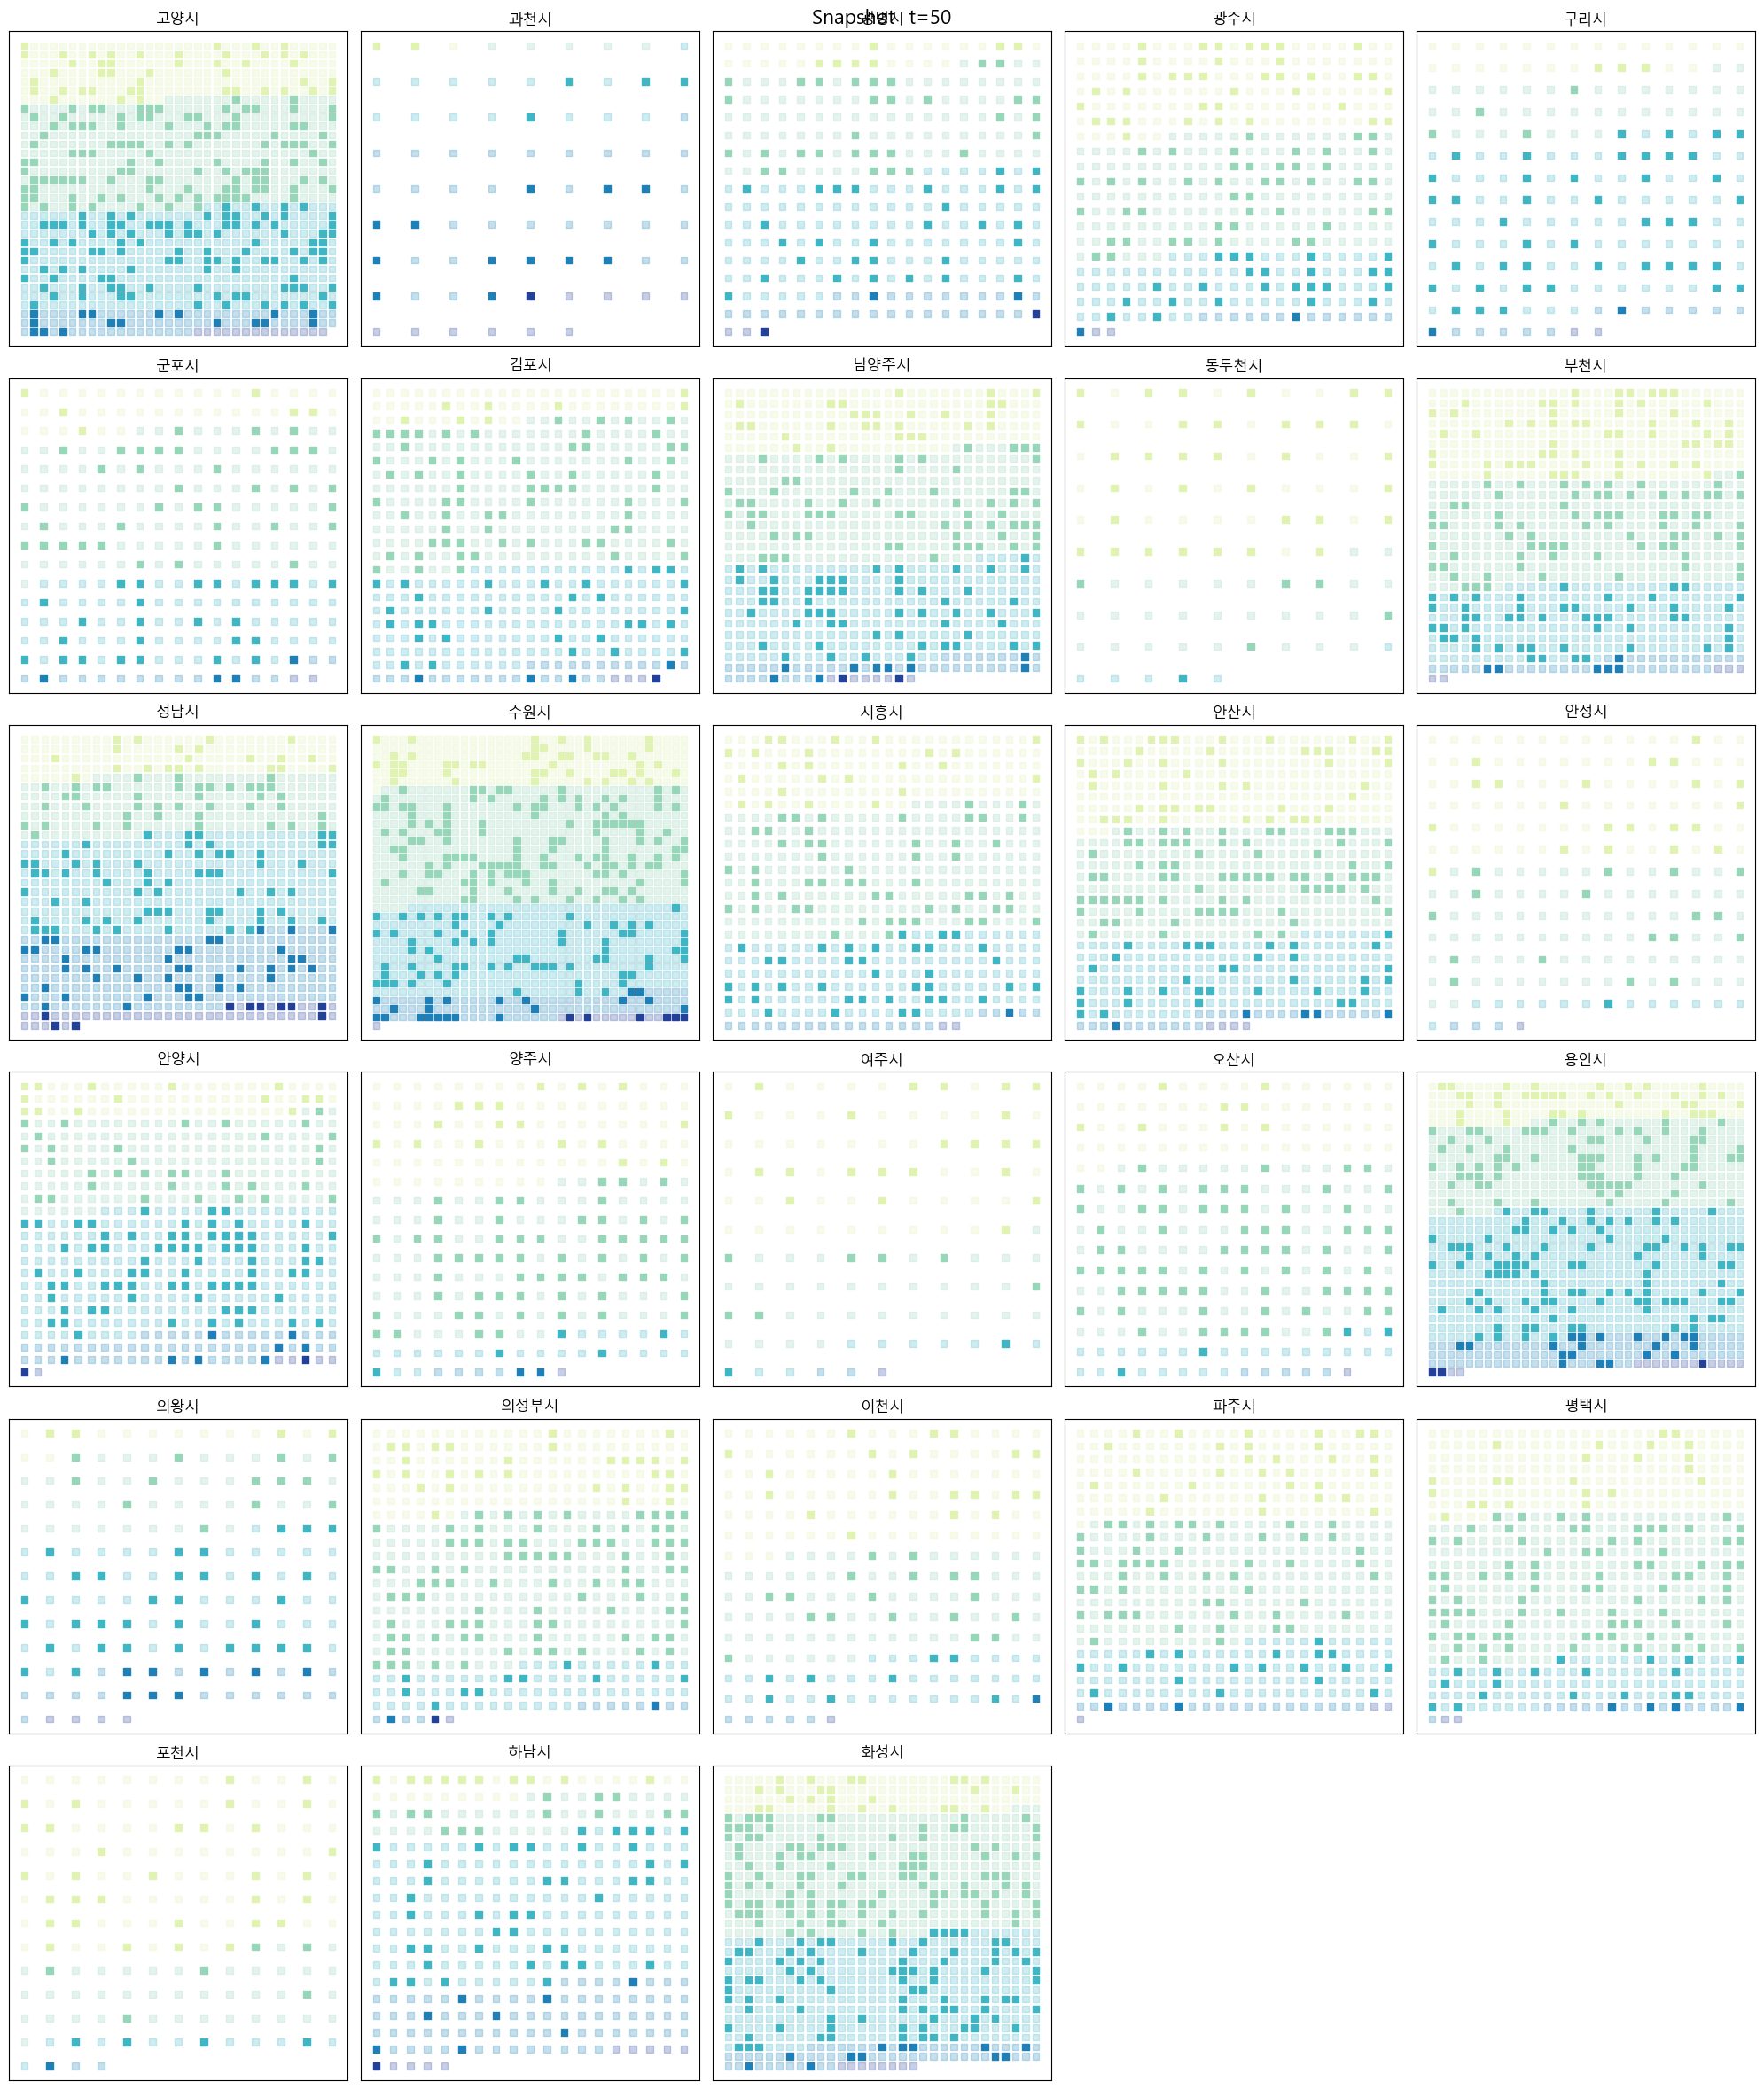

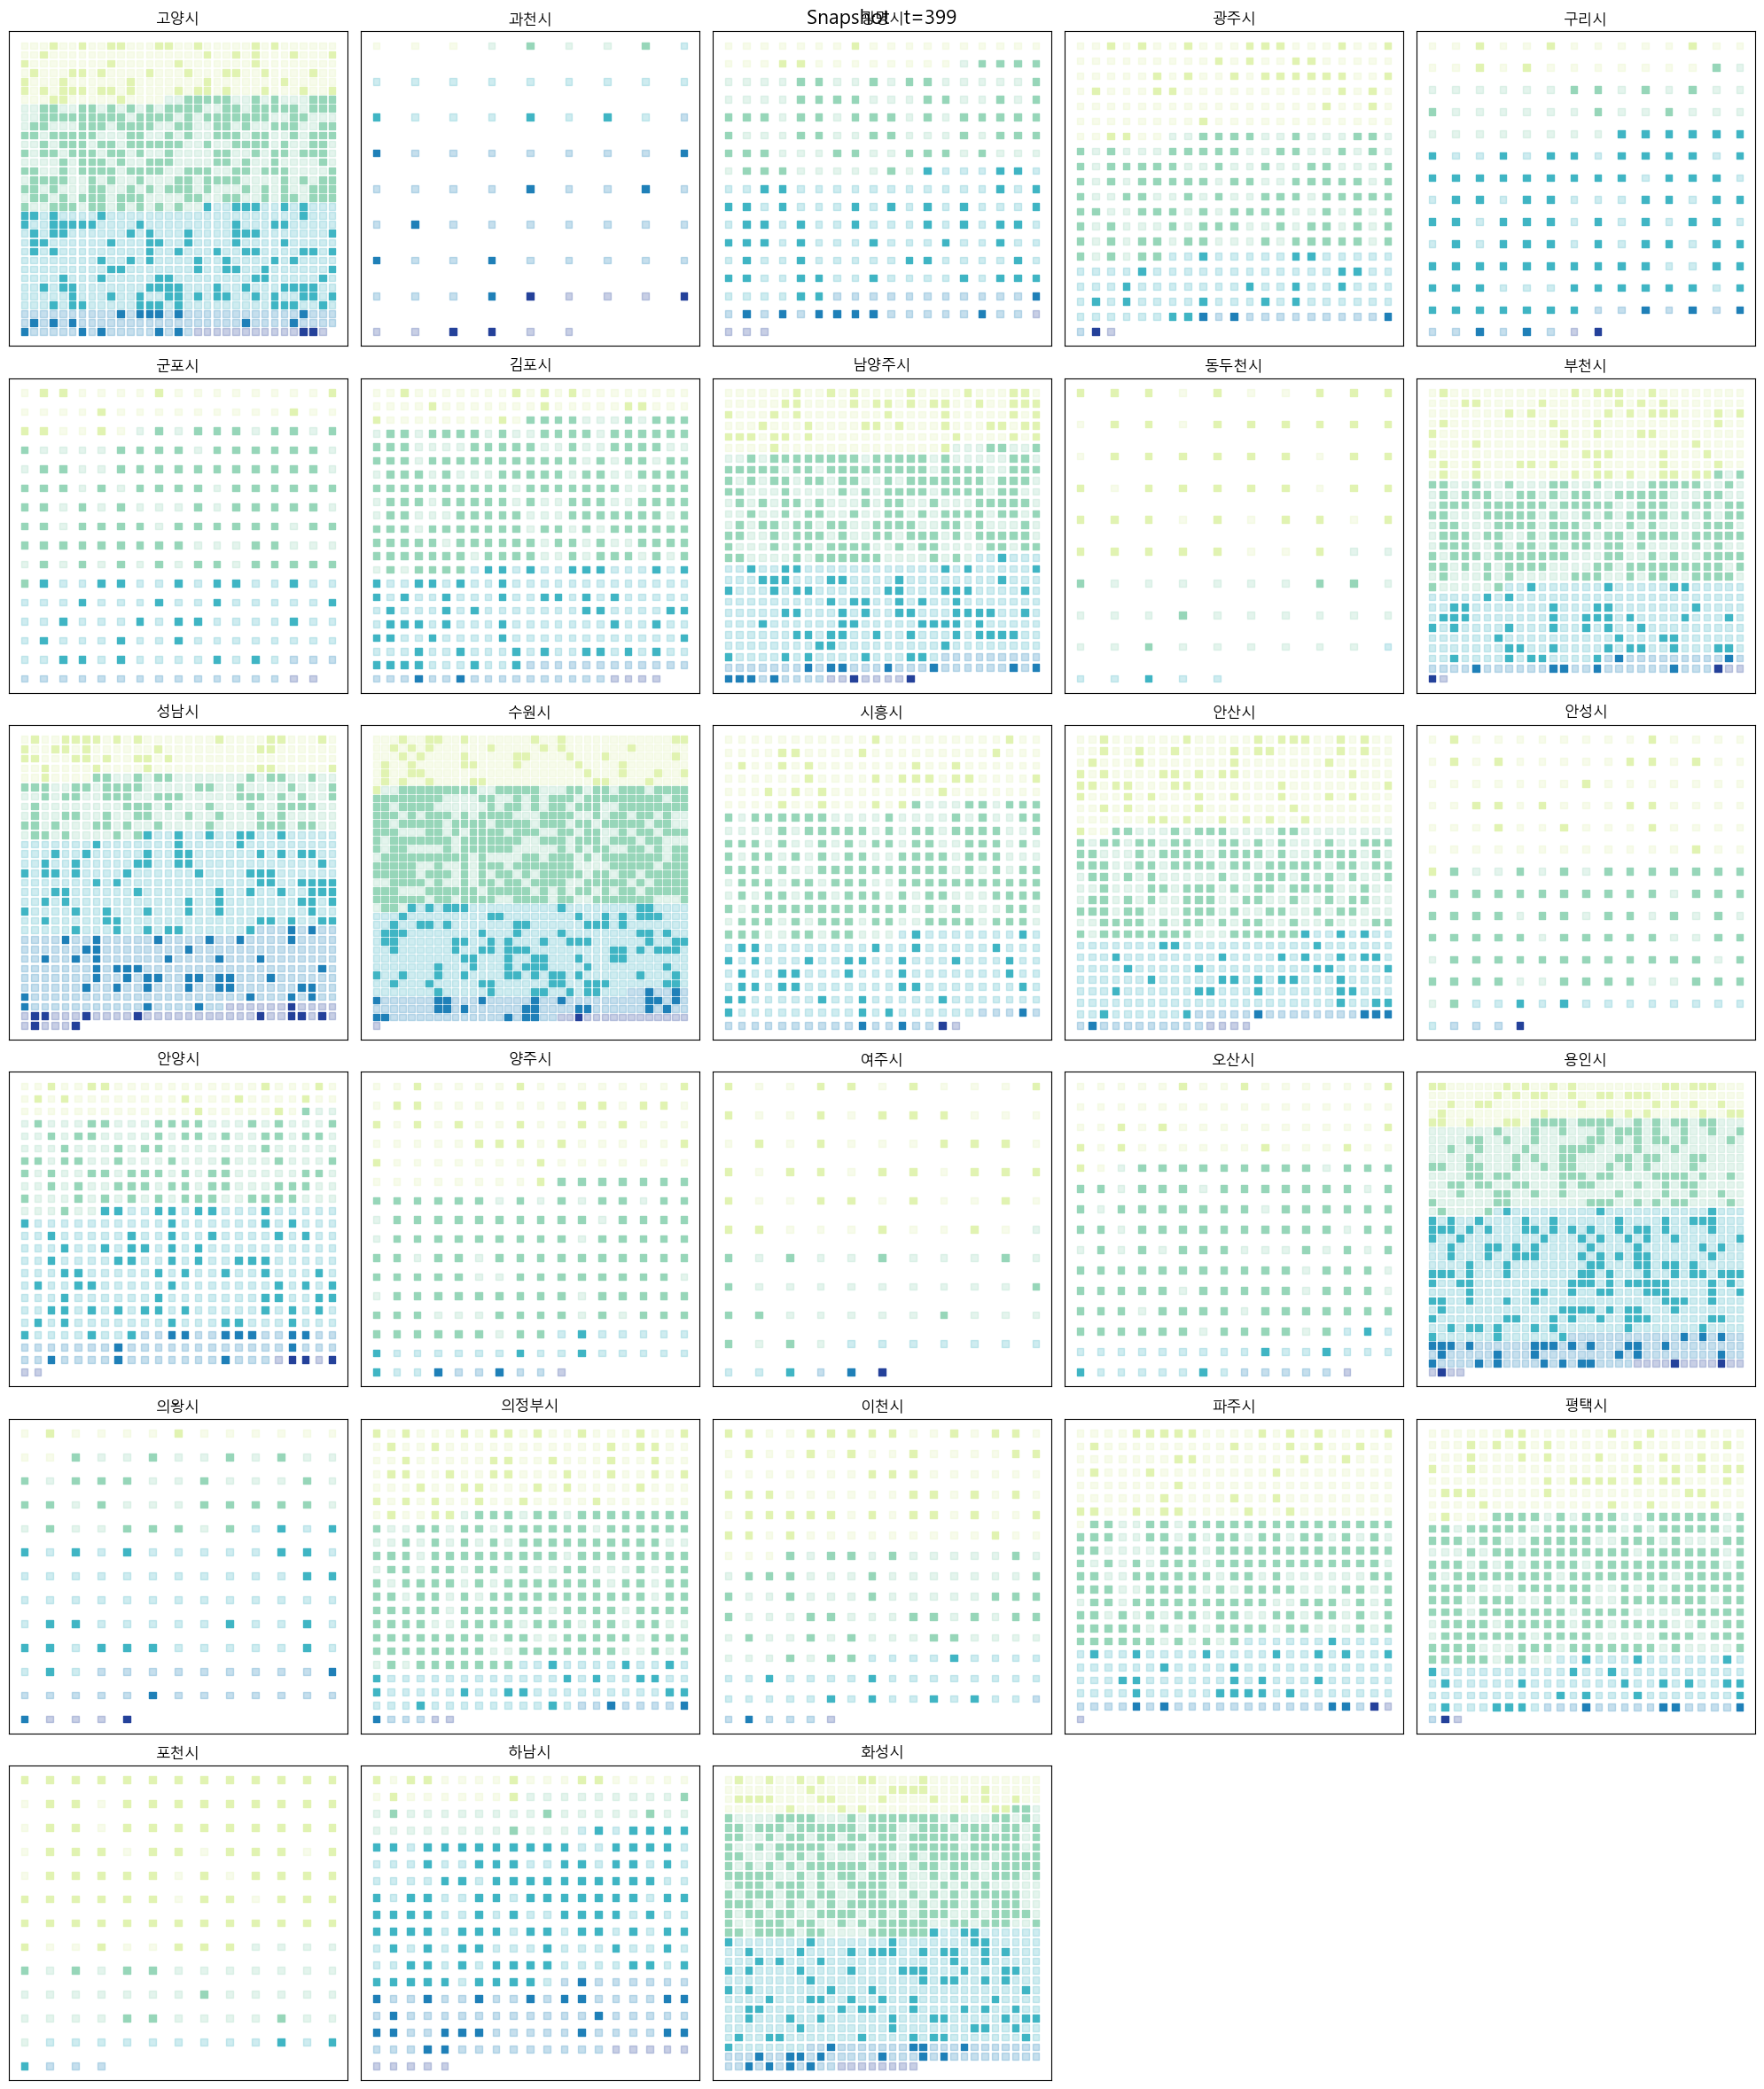

In [12]:
if True:
    plotter = SimulationPlotter(sim)
    plotter.print_final_results()
    plotter.plot_group_adoption_rates()
    plotter.plot_polarization()
    plotter.plot_snapshot(time_step=0)
    plotter.plot_snapshot(time_step=35)
    plotter.plot_snapshot(time_step=50)
    plotter.plot_snapshot(time_step=399)

In [11]:
def run_b_sim(b_val: float, idx: int, total_count: int, other_params: dict):
    """
    단일 b 값(b_scalar : 내‧외집단 간 가중치)에 대해 시뮬레이션을 1회 실행하고
    (b, 그룹A+B 채택률, 그룹D+E 채택률, 전체 채택률,
     전역 양극화, 로컬 양극화)를 반환한다.
    """
    temp_sim = Simulation(
        # ---------------- 고정 파라미터 ----------------
        n_of_group             = other_params['n_of_group'],
        n_of_agent_per_group   = other_params['n_of_agent_per_group'],
        regions_custom         = other_params.get('regions_custom', False),
        region_matrix          = other_params.get('region_matrix', None),
        populations_custom     = other_params.get('populations_custom', False),
        population_matrixs     = other_params.get('population_matrixs', None),
        weights_custom         = other_params.get('weights_custom', False),
        weights_matrix         = other_params.get('weights_matrix', None),

        m                      = other_params['m'],
        f                      = other_params['f'],
        mu                     = other_params['mu'],
        lambda_param           = other_params['lambda_param'],
        init_adopt_n           = other_params['init_adopt_n'],
        init_adopt_patch_index = other_params['init_adopt_patch_index'],
        info_scope             = other_params.get('info_scope', 'global'),
        store_states           = False,

        # ---------------- 가변 파라미터 ----------------
        b_scalar               = b_val,
    )

    temp_sim.run_simulation(max_time_steps=other_params['max_time_steps'])

    # 그룹 A(0)‧B(1) 평균, D(3)‧E(4) 평균
    g01_final = (
        temp_sim.group_rate_history[0][-1] + temp_sim.group_rate_history[1][-1]
    ) / 2
    g34_final = (
        temp_sim.group_rate_history[3][-1] + temp_sim.group_rate_history[4][-1]
    ) / 2

    total_final = temp_sim.total_rate_history[-1]
    gp_final    = temp_sim.global_pol_history[-1]
    lp_final    = temp_sim.local_pol_history[-1]

    return (b_val, g01_final, g34_final, total_final, gp_final, lp_final)


def run_parameter_sweep_for_b_parallel(
    b_values: np.ndarray | list,
    other_params: dict,
    n_jobs: int = -1,
    save_excel: bool = False,
    excel_filename: str = "b_sweep_results.xlsx",
):
    """
    b_scalar(0 ~ 1)를 변화시키며 시뮬레이션을 병렬로 수행한 뒤
    결과를 DataFrame(및 선택적 Excel)으로 반환한다.
    """
    total_count = len(b_values)
    with tqdm_joblib(tqdm(total=total_count, desc="b sweep")):
        results = Parallel(n_jobs=n_jobs)(
            delayed(run_b_sim)(bv, i, total_count, other_params)
            for i, bv in enumerate(b_values)
        )

    df_result = pd.DataFrame(
        results,
        columns=["b", "g01_rate", "g34_rate", "total_rate", "global_pol", "local_pol"],
    )

    # ----- 채택률 그래프 -----
    plt.figure(figsize=(5, 3))
    plt.plot(df_result["b"], df_result["g01_rate"], label="Marker A+B")
    plt.plot(df_result["b"], df_result["g34_rate"], label="Marker D+E")
    plt.plot(df_result["b"], df_result["total_rate"], label="Total")
    plt.xlabel("b_scalar")
    plt.ylabel("Adoption Rate")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----- 전역 양극화 -----
    plt.figure(figsize=(5, 3))
    plt.plot(df_result["b"], df_result["global_pol"], label="Global Pol")
    plt.xlabel("b_scalar")
    plt.ylabel("Polarization")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----- 로컬 양극화 -----
    plt.figure(figsize=(5, 3))
    plt.plot(df_result["b"], df_result["local_pol"], label="Local Pol")
    plt.xlabel("b_scalar")
    plt.ylabel("Polarization")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (선택) Excel 저장
    if save_excel:
        df_result.to_excel(excel_filename, index=False)
        print(f"결과가 Excel 파일로 저장되었습니다: {excel_filename}")

    return df_result


# -------------------------------------------------------------------------
# 예시 실행 블록 (오류 방지용·주피터에서 직접 True로 바꿔 사용)
# -------------------------------------------------------------------------
if False:
    b_list = np.linspace(0, 1, 101)        # 0.00, 0.02, … , 1.00

    param_dict_for_b = {
        'n_of_group'            : 28,
        'n_of_agent_per_group'  : 500,
        'regions_custom'        : True,
        'region_matrix'         : regions_matrixs,
        'populations_custom'    : True,
        'population_matrixs'    : populations_matrixs,
        'weights_custom'        : False,

        'm'                     : 30,
        'f'                     : 0.7,
        'mu'                    : 0.05,
        'lambda_param'          : 0.3,
        'init_adopt_n'          : 5,
        'init_adopt_patch_index': 0,

        'max_time_steps'        : 300,
    }

    df_b = run_parameter_sweep_for_b_parallel(
        b_list,
        param_dict_for_b,
        save_excel=True,
        excel_filename="b_sweep_results.xlsx",
    )
    print(df_b.head())